In [1]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.strategies.trixMulti import TrixMulti
from utilities.bt_analysis import get_metrics, multi_backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [4]:
exchange_name = "binance"
leverage = 1
start_date = "2020-01-01"
end_date = None
strategy_type = ["long"]


dict_params = {
    "1h": {
        "p1": {
            "BTC/USDT": {"trix_length": 19, "trix_signal_length": 15, "trix_signal_type": "sma", "long_ma_length": 500,},
            "ETH/USDT": {"trix_length": 21, "trix_signal_length": 9, "trix_signal_type": "ema", "long_ma_length": 500,},
            "SOL/USDT": {"trix_length": 11, "trix_signal_length": 9, "trix_signal_type": "sma", "long_ma_length": 500,},
            "PEPE/USDT": {"trix_length": 33, "trix_signal_length": 41, "trix_signal_type": "ema", "long_ma_length": 500,},
        },
        "p2": {
            "BTC/USDT": {"trix_length": 13, "trix_signal_length": 41, "trix_signal_type": "sma", "long_ma_length": 500,},
            "ETH/USDT": {"trix_length": 13, "trix_signal_length": 37, "trix_signal_type": "ema", "long_ma_length": 500,},
            "SOL/USDT": {"trix_length": 9, "trix_signal_length": 23, "trix_signal_type": "sma", "long_ma_length": 500,},
            "PEPE/USDT": {"trix_length": 37, "trix_signal_length": 27, "trix_signal_type": "ema", "long_ma_length": 500,},
        },
    },
    "2h": {
        "p1": {
            "BTC/USDT": {"trix_length": 7, "trix_signal_length": 11, "trix_signal_type": "ema", "long_ma_length": 300,},
            "ETH/USDT": {"trix_length": 21, "trix_signal_length": 47, "trix_signal_type": "sma", "long_ma_length": 300,},
            "SOL/USDT": {"trix_length": 5, "trix_signal_length": 5, "trix_signal_type": "ema", "long_ma_length": 300,},
            "PEPE/USDT": {"trix_length": 25, "trix_signal_length": 5, "trix_signal_type": "ema", "long_ma_length": 300,},
        },
        "p2": {
            "BTC/USDT": {"trix_length": 41, "trix_signal_length": 7, "trix_signal_type": "ema", "long_ma_length": 300,},
            "ETH/USDT": {"trix_length": 39, "trix_signal_length": 7, "trix_signal_type": "sma", "long_ma_length": 300,},
            "SOL/USDT": {"trix_length": 47, "trix_signal_length": 47, "trix_signal_type": "ema", "long_ma_length": 300,},
            "PEPE/USDT": {"trix_length": 43, "trix_signal_length": 29, "trix_signal_type": "sma", "long_ma_length": 200,},
        },
    },
    "4h": {
        "p1": {
            "BTC/USDT": {"trix_length": 11, "trix_signal_length": 45, "trix_signal_type": "ema", "long_ma_length": 200,},
            "ETH/USDT": {"trix_length": 19, "trix_signal_length": 7, "trix_signal_type": "ema", "long_ma_length": 200,},
            "SOL/USDT": {"trix_length": 41, "trix_signal_length": 7, "trix_signal_type": "ema", "long_ma_length": 200,},
            "PEPE/USDT": {"trix_length": 49, "trix_signal_length": 49, "trix_signal_type": "ema", "long_ma_length": 400,},
        },
        "p2": {
            "BTC/USDT": {"trix_length": 5, "trix_signal_length": 7, "trix_signal_type": "ema", "long_ma_length": 200,},
            "ETH/USDT": {"trix_length": 9, "trix_signal_length": 47, "trix_signal_type": "ema", "long_ma_length": 200,},
            "SOL/USDT": {"trix_length": 25, "trix_signal_length": 41, "trix_signal_type": "ema", "long_ma_length": 200,},
            "PEPE/USDT": {"trix_length": 21, "trix_signal_length": 19, "trix_signal_type": "sma", "long_ma_length": 200,},
        },
    },
}

oldest_pair = "1h-p1-BTC/USDT"

In [5]:
exchange = ExchangeDataManager(
    exchange_name=exchange_name, path_download="../database/exchanges"
)

df_list = {}

total_size = sum(
    obj["size"]
    for timeframe in dict_params.values()
    for params in timeframe.values()
    for obj in params.values()
    if "size" in obj
)
if total_size > 1:
    print("Warning: Total size is greater than 1")

no_size_number = len(
    [
        obj
        for timeframe in dict_params.values()
        for params in timeframe.values()
        for obj in params.values()
        if "size" not in obj
    ]
)

params = {}

for tf in dict_params:
    for param in dict_params[tf]:
        for pair in dict_params[tf][param]:
            if "size" not in dict_params[tf][param][pair]:
                dict_params[tf][param][pair]["size"] = max(1-total_size, 0) / no_size_number

            params[f"{tf}-{param}-{pair}"] = dict_params[tf][param][pair]

            df = exchange.load_data(pair, tf)
            df["pair"] = pair
            df["tf"] = tf


            df_list[f"{tf}-{param}-{pair}"] = df.loc[:]

print("Data load 100%")

# df_list[oldest_pair]

Data load 100%


In [6]:
strat = TrixMulti(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=strategy_type,
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=leverage, start_date=start_date, end_date=end_date)

df_trades, df_days = multi_backtest_analysis(
    trades=bt_result["trades"],
    days=bt_result["days"],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=False,
    pair_info=True,
    indepedant_trade=True,
)

╒═════════════════════════════════╤══════════════════════════╕
│ Informations générales          │                          │
╞═════════════════════════════════╪══════════════════════════╡
│ Période                         │ 03.01.2020 -> 17.02.2024 │
│ Portefeuille initial            │ 1,000.00 $  (levier x1)  │
│                                 │                          │
│ Portefeuille final              │ 12,011.78 $              │
│ Performance vs US dollar        │ 1,101.18 %               │
│ Pire Drawdown T|D               │ -18.31 % | -19.51 %      │
│ Moyenne journalière Drawdown    │ -6.31 %                  │
│ Buy and hold performance        │ 648.32 %                 │
│ Performance vs buy and hold     │ 60.52 %                  │
│ Nombre total de trades          │ 5243                     │
│ Sharpe | Sortino | Calmar Ratio │ 2.55 | 4.72 | 3.25       │
│ Global Win rate                 │ 43.64 %                  │
│ Profit moyen                    │ 1.29 %             

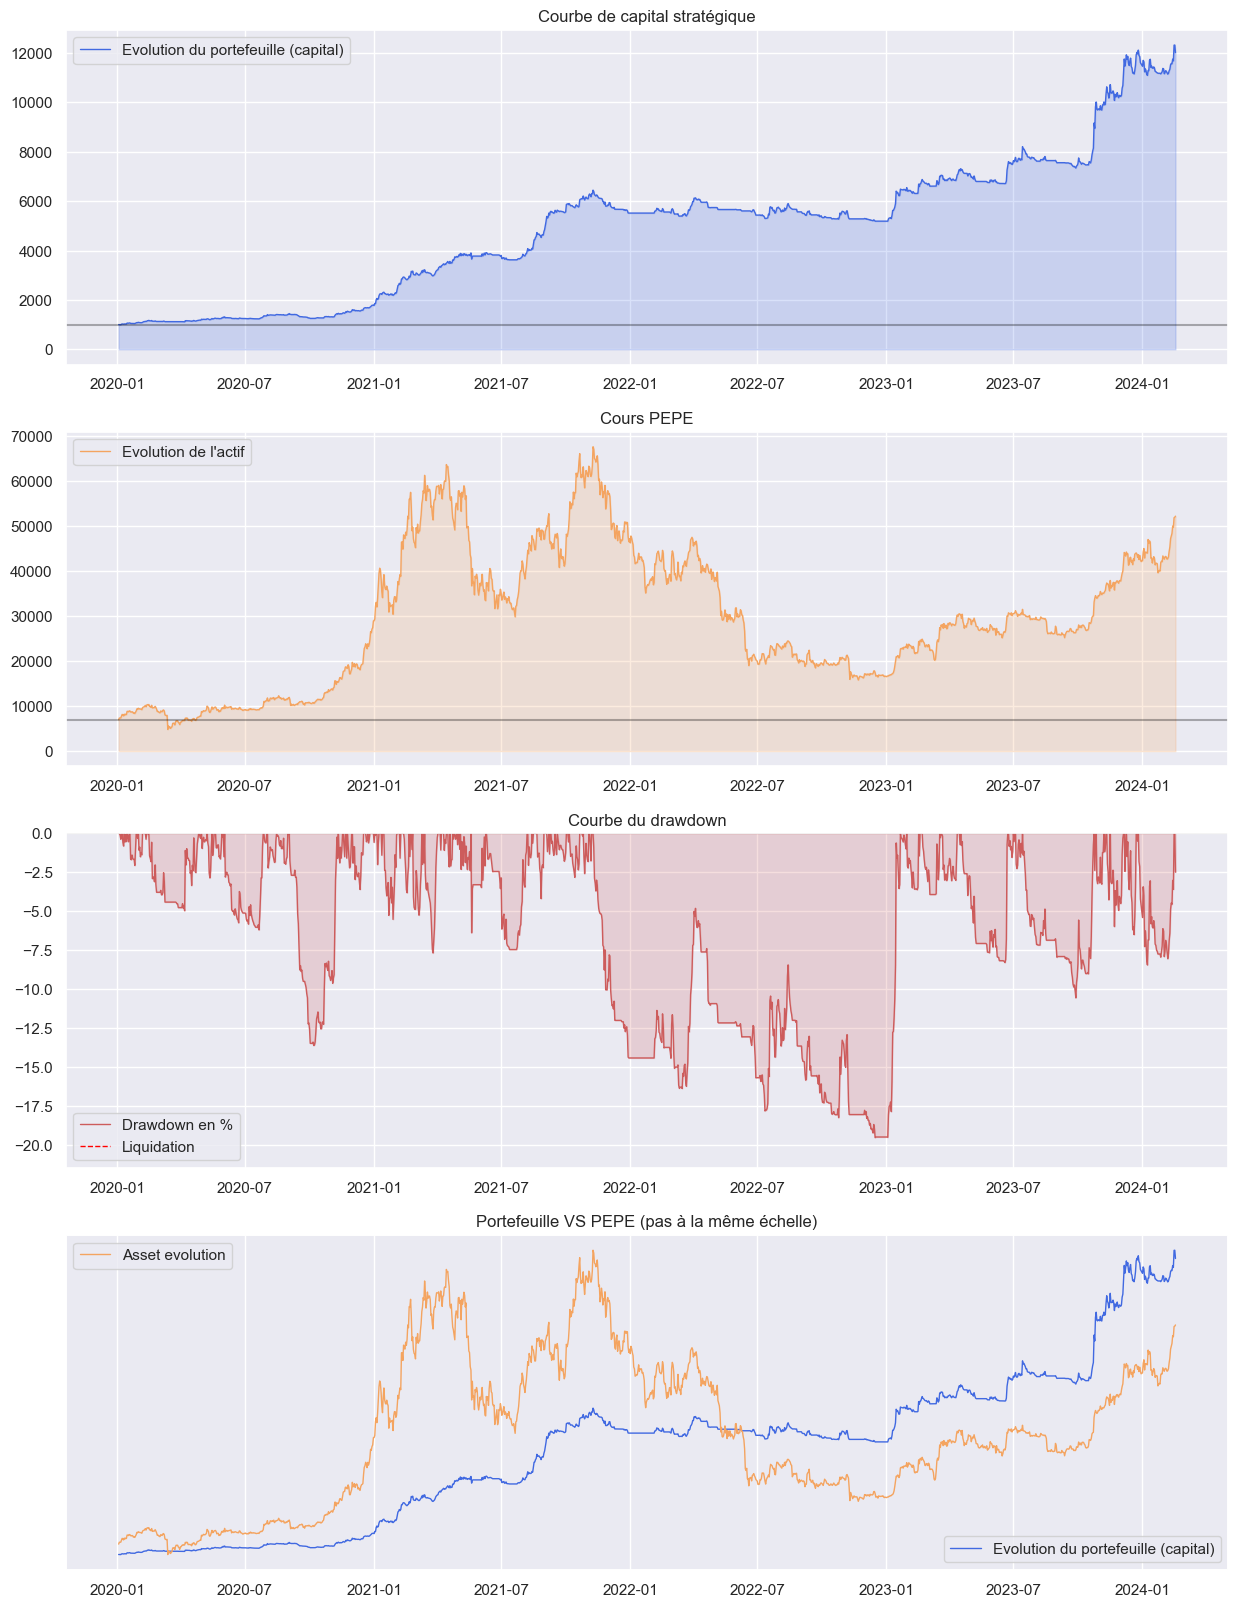

In [78]:
plot_equity_vs_asset(df_days=df_days.loc[:], pair=pair)

In [79]:
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2020-01-03 08:00:00,2h-p1-BTC/USDT,2020-01-03 08:00:00,2020-01-04 08:00:00,LONG,Market,Market,7348.42,7363.88,0.020832,0.020866,41.644098,41.731711,999.879263,0.066781,0.001604,0.000067,1 days 00:00:00,999.879263,0.000000,0.000000
2020-01-03 08:00:00,1h-p1-BTC/USDT,2020-01-03 08:00:00,2020-01-04 10:00:00,LONG,Market,Market,7260.60,7318.30,0.020833,0.020988,41.644966,41.975918,1000.189228,0.310120,0.007447,0.000310,1 days 02:00:00,1000.189228,0.000000,0.000000
2020-01-03 13:00:00,1h-p2-ETH/USDT,2020-01-03 13:00:00,2020-01-04 14:00:00,LONG,Market,Market,133.54,133.06,0.020832,0.020746,41.642363,41.492682,1000.018801,-0.170512,-0.004095,-0.000171,1 days 01:00:00,1000.189228,0.170427,0.000170
2020-01-03 13:00:00,1h-p1-ETH/USDT,2020-01-03 13:00:00,2020-01-04 14:00:00,LONG,Market,Market,133.54,133.06,0.020831,0.020746,41.641495,41.491818,999.848377,-0.170509,-0.004095,-0.000171,1 days 01:00:00,1000.189228,0.340850,0.000341
2020-01-03 08:00:00,1h-p2-BTC/USDT,2020-01-03 08:00:00,2020-01-04 15:00:00,LONG,Market,Market,7260.60,7318.99,0.020832,0.020989,41.643231,41.978127,1000.162285,0.314064,0.007542,0.000314,1 days 07:00:00,1000.189228,0.026943,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12 20:00:00,4h-p2-ETH/USDT,2024-02-12 20:00:00,2024-02-16 20:00:00,LONG,Market,Market,2659.99,2801.80,0.238464,0.251052,476.689987,502.103394,11780.228439,25.174942,0.052812,0.002132,4 days 00:00:00,11780.228439,0.000000,0.000000
2024-02-13 06:00:00,2h-p1-ETH/USDT,2024-02-13 06:00:00,2024-02-16 22:00:00,LONG,Market,Market,2648.64,2801.80,0.238429,0.252091,476.620474,504.181484,11807.537358,27.322580,0.057326,0.002309,3 days 16:00:00,11807.537358,0.000000,0.000000
2024-02-09 00:00:00,4h-p1-SOL/USDT,2024-02-09 00:00:00,2024-02-17 00:00:00,LONG,Market,Market,104.35,109.89,0.232959,0.245204,465.685420,490.408920,11831.769663,24.490541,0.052590,0.002066,8 days 00:00:00,11831.769663,0.000000,0.000000


----- 2020 Cumulative Performances: 78.85% -----


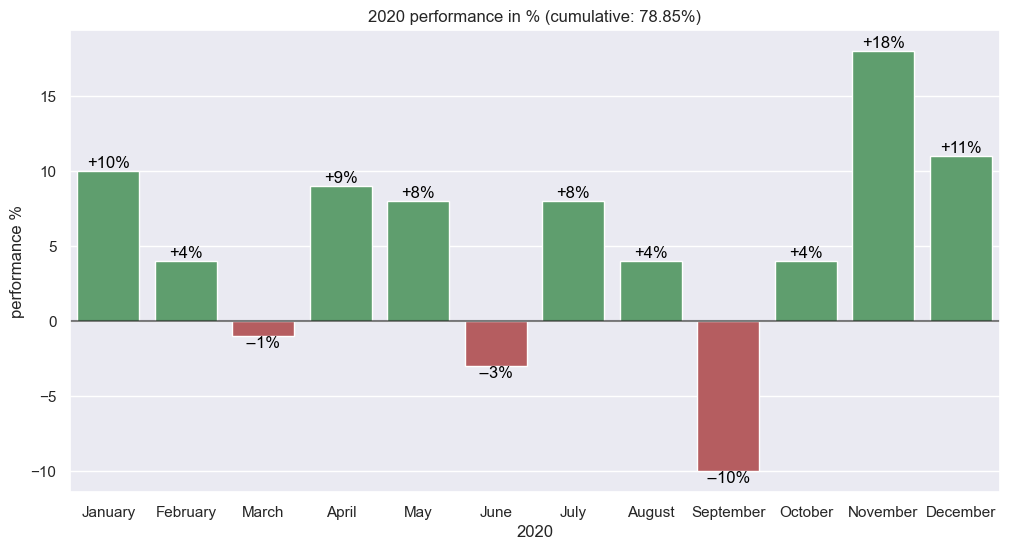

----- 2021 Cumulative Performances: 210.23% -----


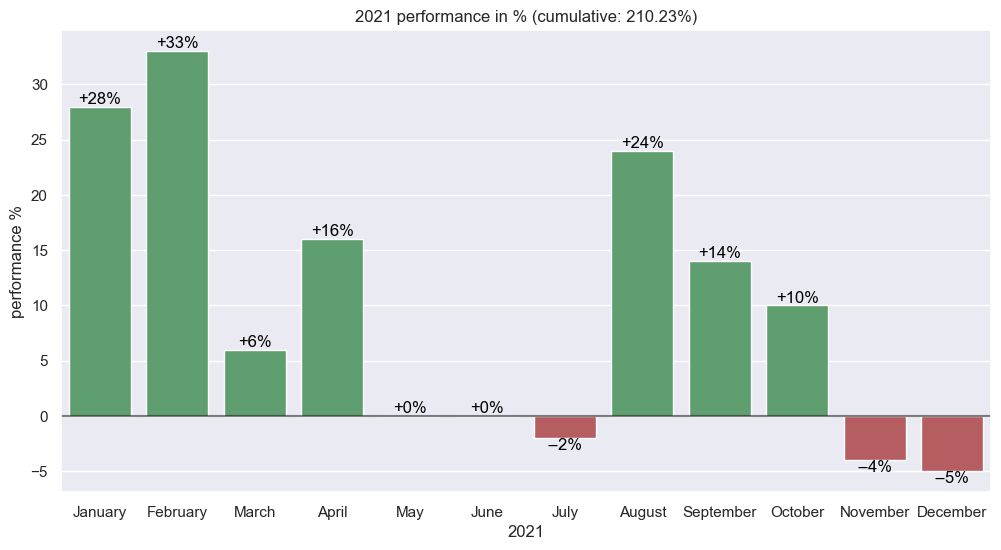

----- 2022 Cumulative Performances: -5.92% -----


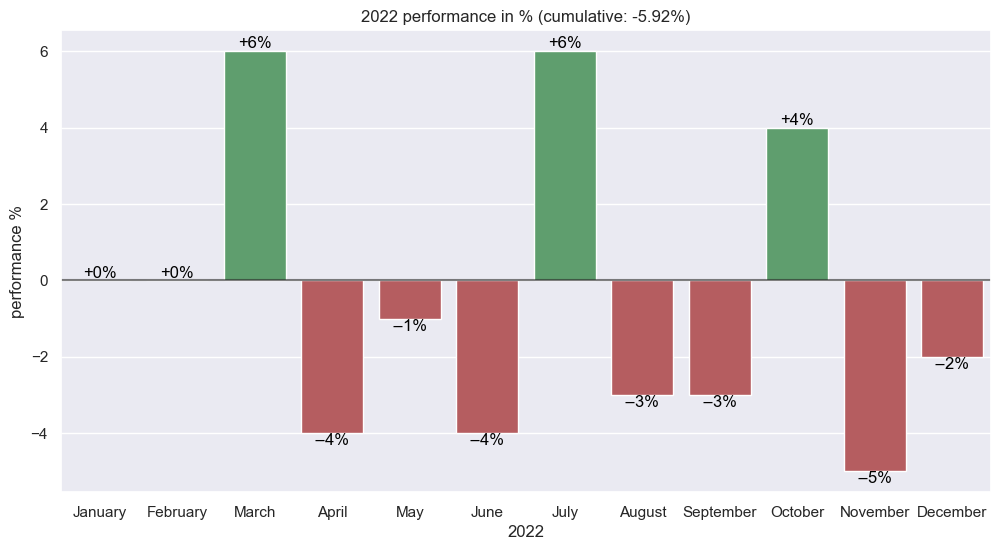

----- 2023 Cumulative Performances: 121.7% -----


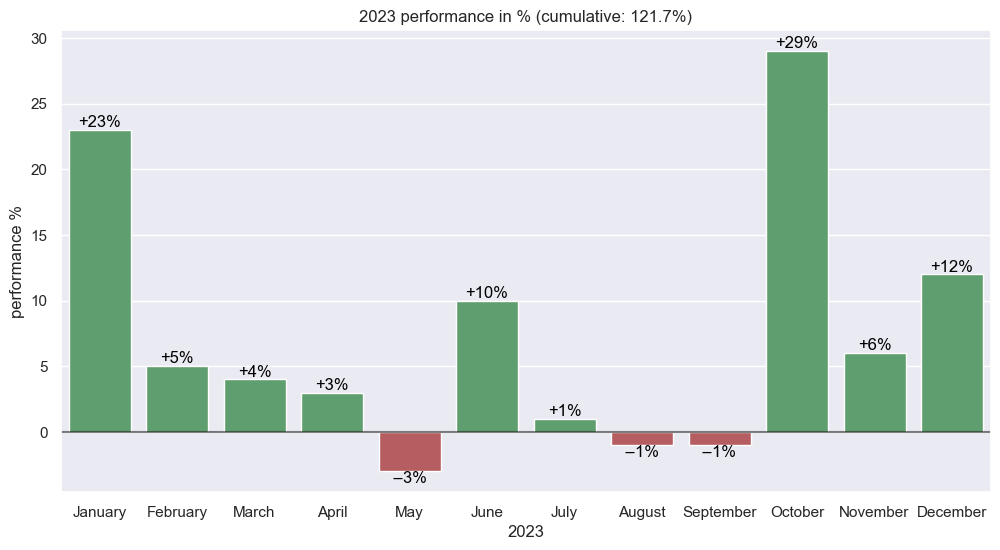

----- 2024 Cumulative Performances: 4.82% -----


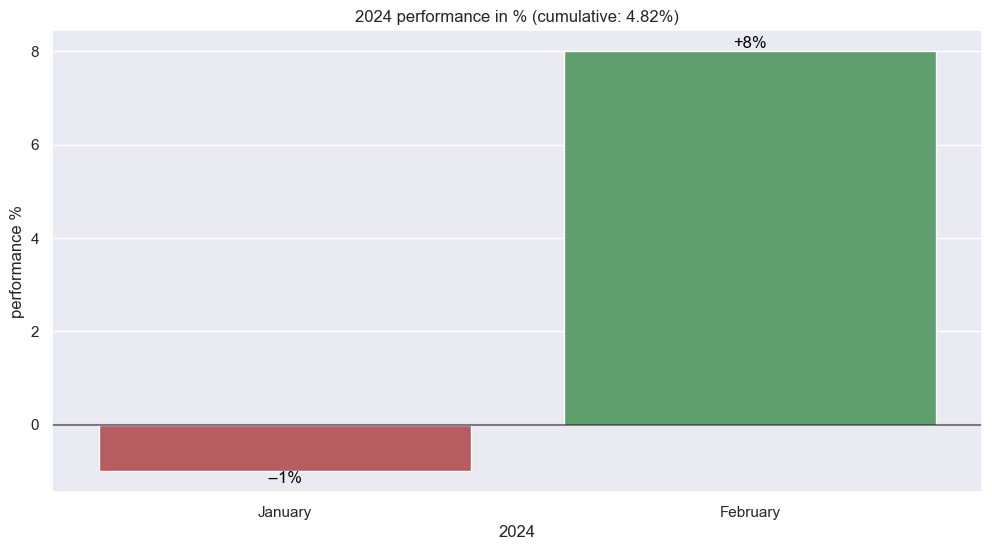

In [80]:
plot_bar_by_month(df_days=df_days)

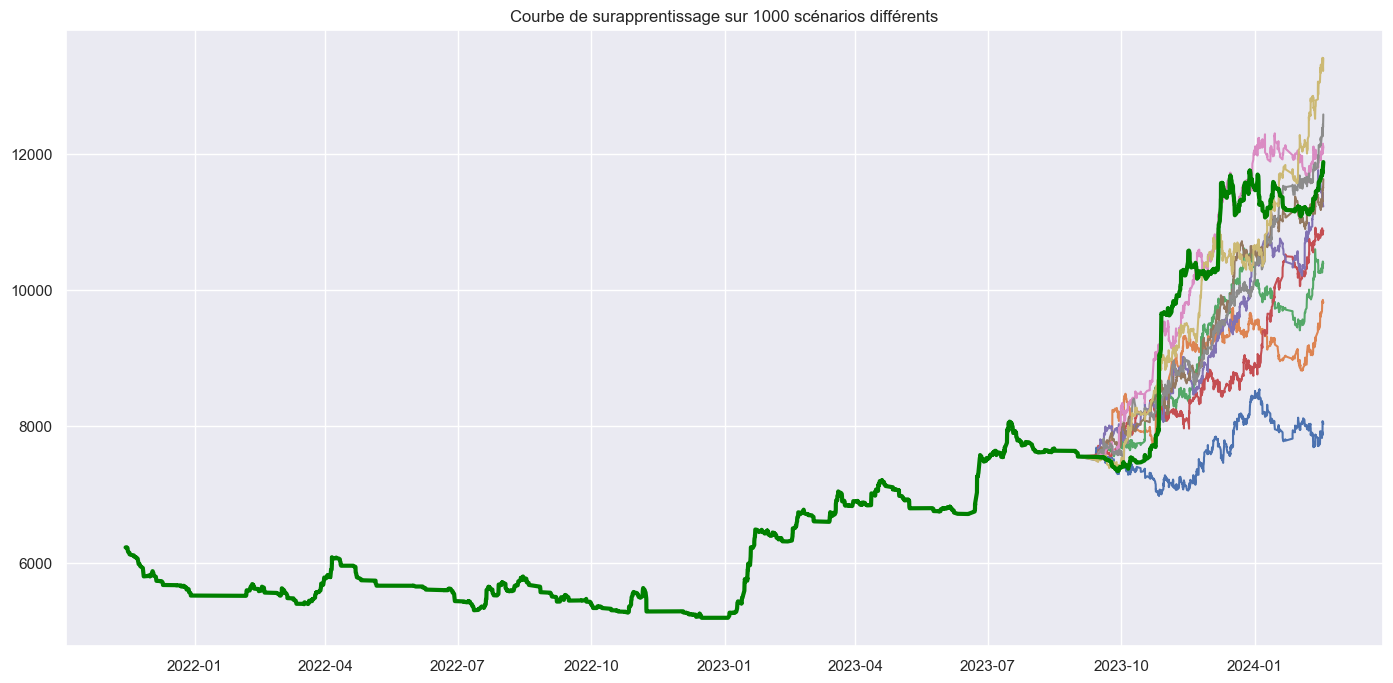

In [81]:
from utilities.plot_analysis import plot_train_test_simulation


plot_train_test_simulation(df_trades, "2023-09-10", 2, 1000)

Optimisations

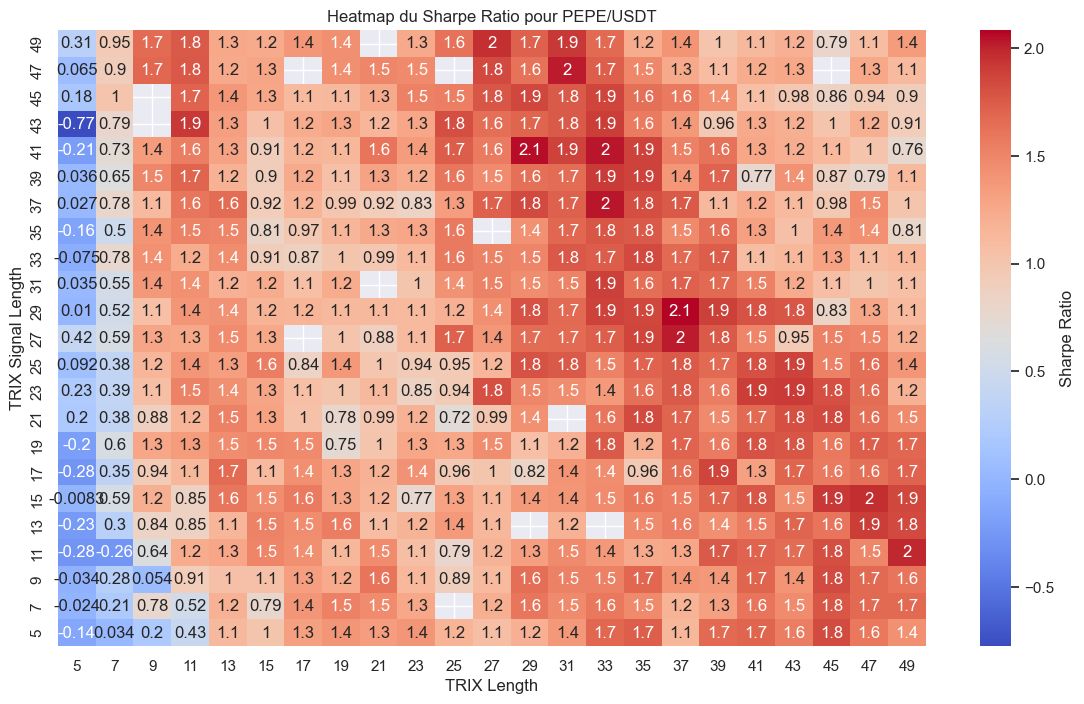

Sharpe Ratio max:  2.2775604777


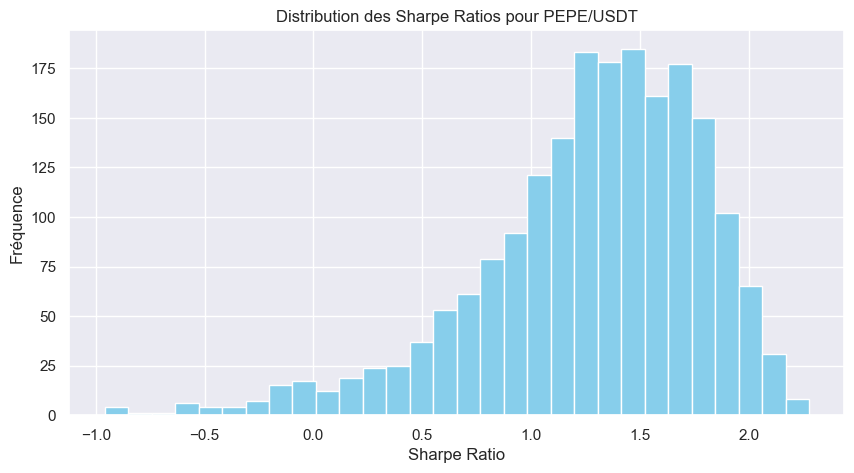

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Charger le fichier Excel
df = pd.read_excel('trix-90-k-optimizations.xlsx')

# Filtrer les données
pair_analyze = 'PEPE/USDT'
btc_data = df[(df['pair'] == pair_analyze) & (df['tf'] == '1h')]

# Créer la table pivot pour la heatmap
heatmap_data = btc_data.pivot_table(values='sharpe_ratio', index='trix_signal_length', columns='trix_length', aggfunc='mean')

# Créer la heatmap avec les données filtrées
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={"label": "Sharpe Ratio"}) 
plt.title('Heatmap du Sharpe Ratio pour ' + pair_analyze)
plt.xlabel('TRIX Length')
plt.ylabel('TRIX Signal Length')
plt.gca().invert_yaxis()
plt.show()

print('Sharpe Ratio max: ', btc_data['sharpe_ratio'].max())

# Histogramme des sharpe_ratio
plt.figure(figsize=(10, 5))
btc_data['sharpe_ratio'].hist(bins=30, color='skyblue')
plt.title('Distribution des Sharpe Ratios pour ' + pair_analyze)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Fréquence')
plt.show()